<a href="https://colab.research.google.com/github/tiyu0203/fml/blob/master/fml_proj6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 475 Project 6: Market Basket Analysis
Tiffany Yu, Jonathan Lam, Harris Paspuleti

The goal of this project is to use market basket analysis to draw interesting inferences (association rules) about some dataset.

In [ ]:
# mlxtend has a priori algorithm implementation
!pip install mlxtend

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Dataset
[FIFA 18 Player Statistics](https://github.com/4m4n5/fifa18-all-player-statistics/)

This dataset contains the attributes for every player that is registered in the latest edition of FIFA 18 database; it can be used for soccer/videogame analysis as it contains attributes such as skill moves, overall, potential, position, etc. While none of us know much about soccer, we wanted to see if there were any interesting assocations we could learn from the data even without knowing much about the sport.

> ### Content
- Every player featuring in FIFA 18
- 70+ attributes
- Player and Flag Images
- Playing Position Data
- Attributes based on actual data of the latest EA's FIFA 18 game
- Attributes include on all player style statistics like Dribbling, Aggression, - GK Skills etc.
- Player personal data like Nationality, Photo, Club, Age, Wage, Salary etc.
> 
> ### Data Source
The data is scraped from the website https://sofifa.com by extracting the Player personal data and Player Ids and then the playing and style statistics.

In [ ]:
# grab the data
raw_data = 'https://raw.githubusercontent.com/4m4n5/fifa18-all-player-statistics/master/2019/data.csv'
dataframe = pd.read_csv(raw_data, sep=',', header='infer', error_bad_lines=False)

## Preprocessing


### Preprocessing Step 1: Drop unusable columns and rows
Some columns were extraneous, included data that we didn't know how to interpret, or included data that was unique to a player. For example, there was a column for the player's index, the player photo, and some fields like "Real Face" that we weren't familiar with. Additionally, there were many rows with acronyms (e.g., "LS", "ST", etc.) with values that we weren't sure how to interpret.

Some rows also had missing data; we dropped this using `pd::dropna()`.

The dataframe after this initial preprocessing step is shown below.

In [ ]:
# preprocessing the data by removing unnecessary columns
dataframe = dataframe.drop(columns=[
    'Unnamed: 0','ID','Photo','Flag','Club Logo','Loaned From','Real Face','LS',
    'ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM','LM','LCM','CM','RCM',
    'RM','LWB','LDM','LB','LCB','CB','RCB','RB','CDM','RDM','RWB'
    ]).dropna()
dataframe

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Position,Jersey Number,Joined,Contract Valid Until,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,RF,10.0,"Jul 1, 2004",2021,5'7,159lbs,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,ST,7.0,"Jul 10, 2018",2022,6'2,183lbs,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,LW,10.0,"Aug 3, 2017",2022,5'9,150lbs,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,GK,1.0,"Jul 1, 2011",2020,6'4,168lbs,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,RCM,7.0,"Aug 30, 2015",2023,5'11,154lbs,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,J. Lundstram,19,England,47,65,Crewe Alexandra,€60K,€1K,1307,Right,1.0,2.0,2.0,Medium/ Medium,Lean,CM,22.0,"May 3, 2017",2019,5'9,134lbs,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
18203,N. Christoffersson,19,Sweden,47,63,Trelleborgs FF,€60K,€1K,1098,Right,1.0,2.0,2.0,Medium/ Medium,Normal,ST,21.0,"Mar 19, 2018",2020,6'3,170lbs,23.0,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,39.0,38.0,40.0,52.0,41.0,47.0,43.0,67.0,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,€113K
18204,B. Worman,16,England,47,67,Cambridge United,€60K,€1K,1189,Right,1.0,3.0,2.0,Medium/ Medium,Normal,ST,33.0,"Jul 1, 2017",2021,5'8,148lbs,25.0,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,69.0,50.0,47.0,58.0,45.0,60.0,55.0,32.0,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,€165K
18205,D. Walker-Rice,17,England,47,66,Tranmere Rovers,€60K,€1K,1228,Right,1.0,3.0,2.0,Medium/ Medium,Lean,RW,34.0,"Apr 24, 2018",2019,5'10,154lbs,44.0,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,60.0,52.0,21.0,71.0,64.0,42.0,40.0,48.0,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,€143K


### Preprocessing Step 2: Determining bins
Before binning features, we plotted histograms of some of the quantitative fields so that we could see what the distributions look like.

Since this is a videogame, much of the numerical ratings were presented as numbers out of 100, so we decided that binning most fields into quartiles was good enough for our purposes. (Using larger bins was also problematic because of the amount of time it took to run the algorithm with more items.)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


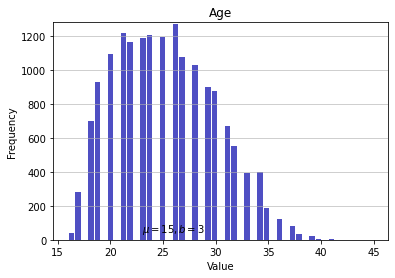

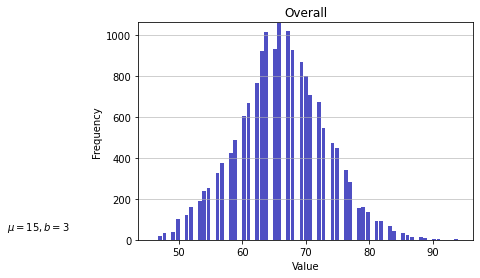

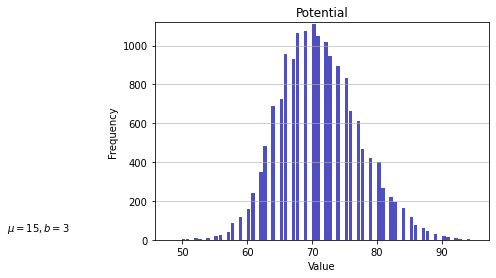

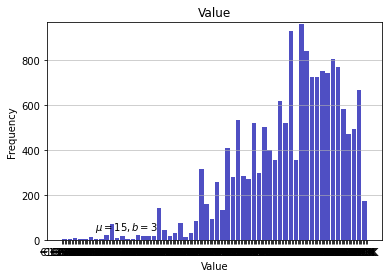

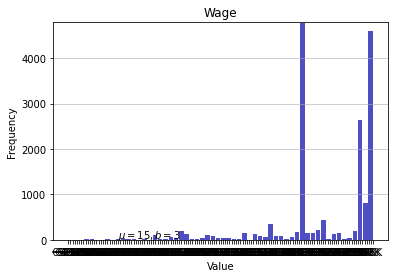

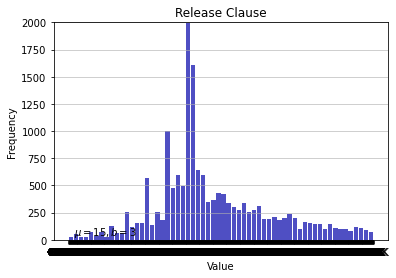

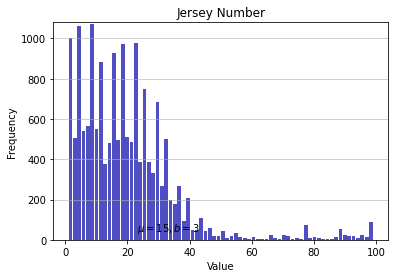

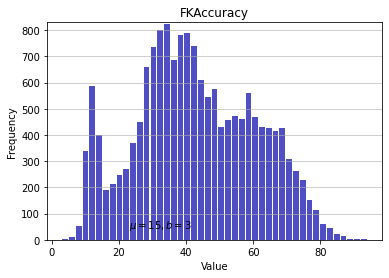

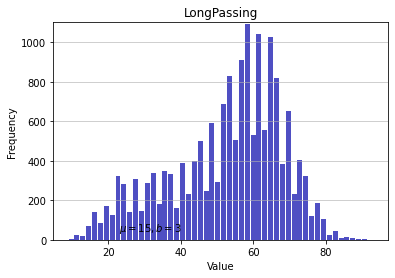

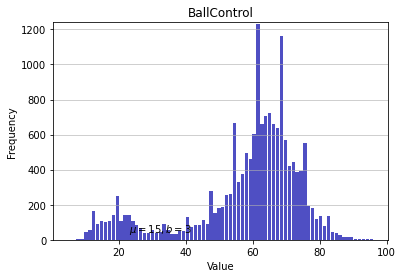

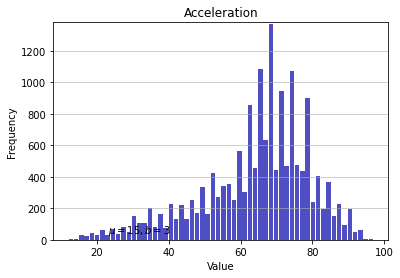

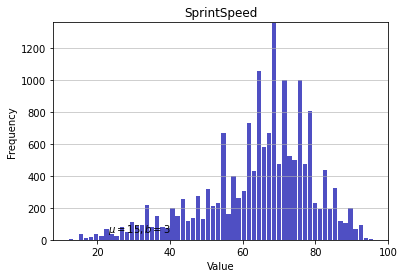

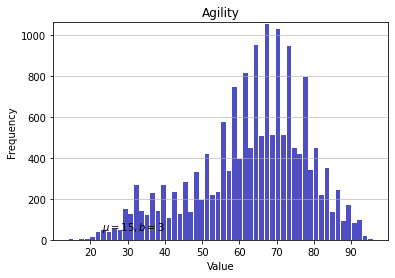

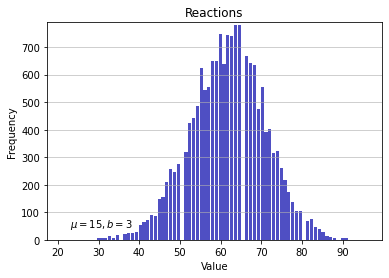

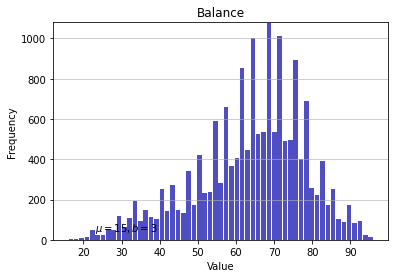

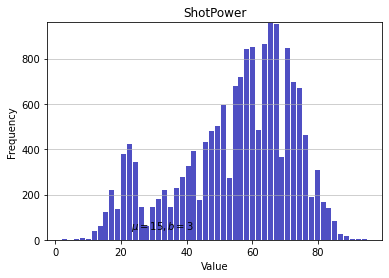

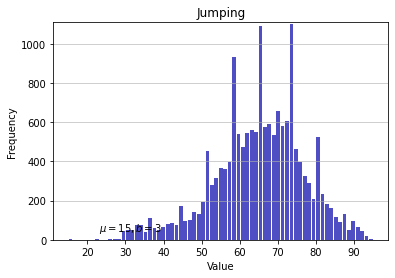

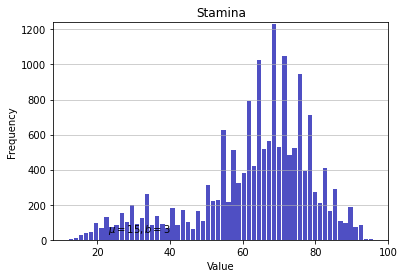

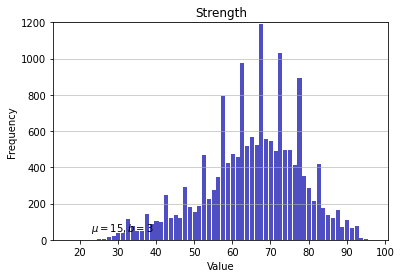

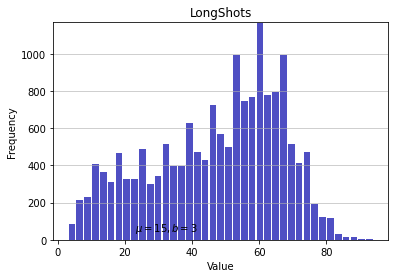

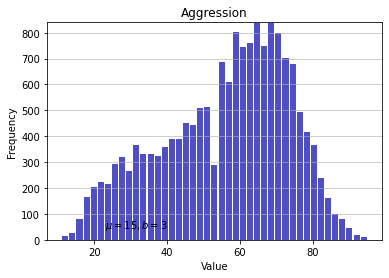

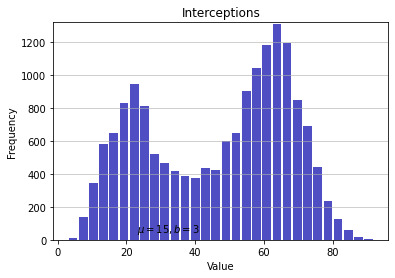

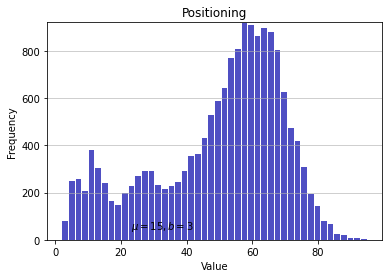

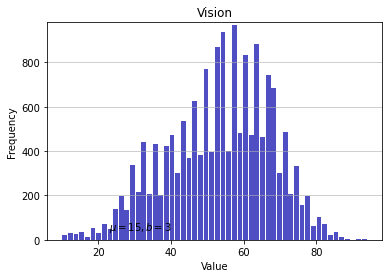

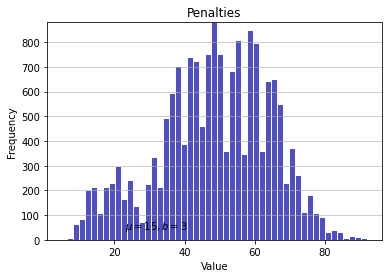

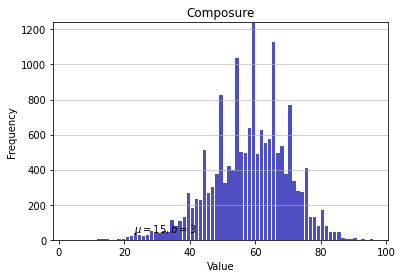

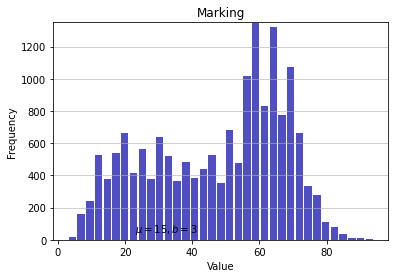

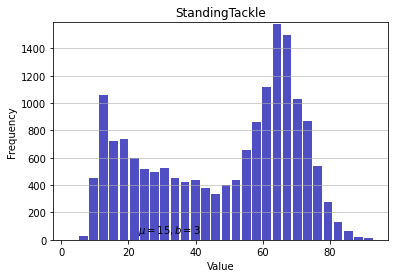

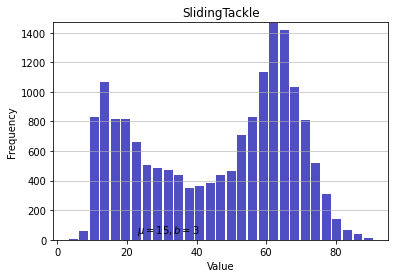

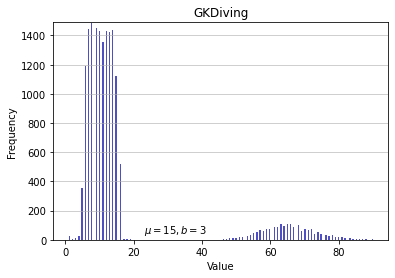

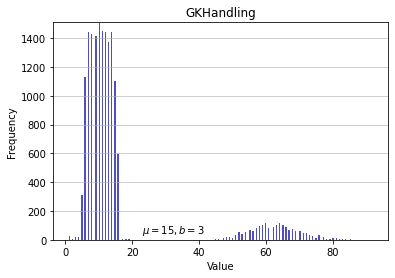

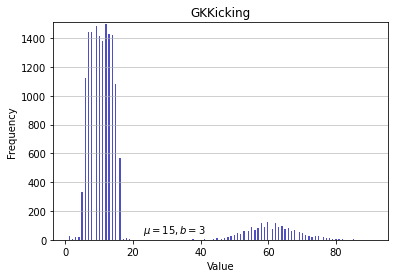

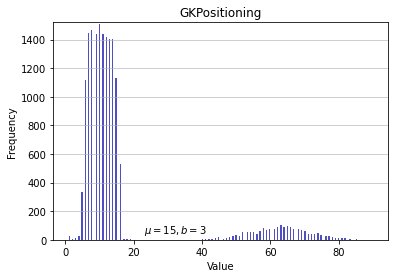

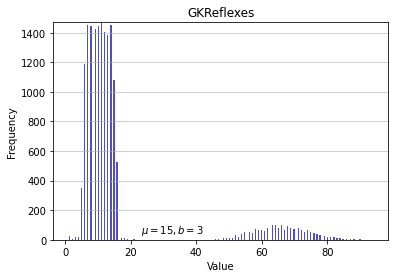

<Figure size 432x288 with 0 Axes>

In [ ]:
# list of numerical fields that can be binned
to_bin = ['Age', 'Overall', 'Potential', 'Value', 'Wage', 'Release Clause',
    'Jersey Number', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
    'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping',
    'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions',
    'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking',
    'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking',
    'GKPositioning', 'GKReflexes'
]

# histograms; see: https://realpython.com/python-histograms/
for col in to_bin:
    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(x=dataframe.loc[:, col], bins='auto', color='#0504aa',
                                alpha=0.7, rwidth=0.85)
    plt.title(col)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.text(23, 45, r'$\mu=15, b=3$')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.figure()


### Preprocessing Step 3: Extracting numbers and binning

Some of the numerical fields were formatted, and the numerical value had to be extracted first before binning. For example, money values were written with a euro sign prefix and the magnitude was indicated with a "M" or "K" postfix (indicating millions or thousands).

We decided to bin the players' ages into bins of age 10, and monetary values (e.g., "Wage," "Release Clause," "Value") into logarithmic bins. Most of the player stats are values between 0 and 100, and we decided to bin these into quartiles (larger bins would be noninformative, and smaller bins would make the algorithm take too long).

The dataframe of the binned values is shown below the code.

In [ ]:
# binning quantitative values
def bin(col, bins, col_name):
    new_col = col.copy()
    
    for i, bin_min in enumerate(bins):
        bin_max = float('Inf') if i==len(bins)-1 else bins[i+1]
        new_col[(col >= bin_min) & (col < bin_max)] = f'{bin_min}<={col_name}<{bin_max}'
  
    return new_col

# make a money column a number
def money_to_number(df_col):
    col = df_col.copy()
  
    for i, val in enumerate(col):
        if val[-1] == 'M':
            val = int(float(val[1:-1]) * 1000000)
        elif val[-1] == 'K':
            val = int(float(val[1:-1]) * 1000)
        else:
            val = int(float(val[1:]))
        col.iloc[i] = val
    
    return col.astype('int32')
  
# create a copy so we don't modify the original dataframe in place
dataframe_binned = dataframe.copy()

dataframe_binned.loc[:, 'Age'] = bin(dataframe.loc[:, 'Age'],
                                     [0, 10, 20, 30, 40, 50], 'Age')
dataframe_binned.loc[:, 'Overall'] = bin(dataframe.loc[:, 'Overall'],
                                         [0, 25, 50, 75, 100], 'Overall')
dataframe_binned.loc[:, 'Potential'] = bin(dataframe.loc[:, 'Potential'],
                                           [25, 50, 75, 100], 'Potential')
dataframe_binned.loc[:, 'Value'] = bin(money_to_number(dataframe.loc[:, 'Value']),
                                       [0, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9], 'Value')
dataframe_binned.loc[:, 'Wage'] = bin(money_to_number(dataframe.loc[:, 'Wage']),
                                      [0, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9], 'Wage')
dataframe_binned.loc[:, 'Release Clause'] = bin(money_to_number(dataframe.loc[:, 'Release Clause']),
                                                [0, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9], 'Release Clause')
 
to_bin = [
    'Jersey Number', 'FKAccuracy', 'LongPassing', 'BallControl',
    'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
    'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
    'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
    'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
    'GKKicking', 'GKPositioning', 'GKReflexes']

for col in to_bin:
    dataframe_binned.loc[:, col] = bin(dataframe.loc[:, col], [0, 25, 50, 75, 100], col)
dataframe_binned

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Position,Jersey Number,Joined,Contract Valid Until,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,L. Messi,30<=Age<40,Argentina,75<=Overall<100,75<=Potential<100,FC Barcelona,100000000.0<=Value<1000000000.0,100000.0<=Wage<1000000.0,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,RF,0<=Jersey Number<25,"Jul 1, 2004",2021,5'7,159lbs,84.0,95.0,70.0,90.0,86.0,97.0,93.0,75<=FKAccuracy<100,75<=LongPassing<100,75<=BallControl<100,75<=Acceleration<100,75<=SprintSpeed<100,75<=Agility<100,75<=Reactions<100,75<=Balance<100,75<=ShotPower<100,50<=Jumping<75,50<=Stamina<75,50<=Strength<75,75<=LongShots<100,25<=Aggression<50,0<=Interceptions<25,75<=Positioning<100,75<=Vision<100,75<=Penalties<100,75<=Composure<100,25<=Marking<50,25<=StandingTackle<50,25<=SlidingTackle<50,0<=GKDiving<25,0<=GKHandling<25,0<=GKKicking<25,0<=GKPositioning<25,0<=GKReflexes<25,100000000.0<=Release Clause<1000000000.0
1,Cristiano Ronaldo,30<=Age<40,Portugal,75<=Overall<100,75<=Potential<100,Juventus,10000000.0<=Value<100000000.0,100000.0<=Wage<1000000.0,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,ST,0<=Jersey Number<25,"Jul 10, 2018",2022,6'2,183lbs,84.0,94.0,89.0,81.0,87.0,88.0,81.0,75<=FKAccuracy<100,75<=LongPassing<100,75<=BallControl<100,75<=Acceleration<100,75<=SprintSpeed<100,75<=Agility<100,75<=Reactions<100,50<=Balance<75,75<=ShotPower<100,75<=Jumping<100,75<=Stamina<100,75<=Strength<100,75<=LongShots<100,50<=Aggression<75,25<=Interceptions<50,75<=Positioning<100,75<=Vision<100,75<=Penalties<100,75<=Composure<100,25<=Marking<50,25<=StandingTackle<50,0<=SlidingTackle<25,0<=GKDiving<25,0<=GKHandling<25,0<=GKKicking<25,0<=GKPositioning<25,0<=GKReflexes<25,100000000.0<=Release Clause<1000000000.0
2,Neymar Jr,20<=Age<30,Brazil,75<=Overall<100,75<=Potential<100,Paris Saint-Germain,100000000.0<=Value<1000000000.0,100000.0<=Wage<1000000.0,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,LW,0<=Jersey Number<25,"Aug 3, 2017",2022,5'9,150lbs,79.0,87.0,62.0,84.0,84.0,96.0,88.0,75<=FKAccuracy<100,75<=LongPassing<100,75<=BallControl<100,75<=Acceleration<100,75<=SprintSpeed<100,75<=Agility<100,75<=Reactions<100,75<=Balance<100,75<=ShotPower<100,50<=Jumping<75,75<=Stamina<100,25<=Strength<50,75<=LongShots<100,50<=Aggression<75,25<=Interceptions<50,75<=Positioning<100,75<=Vision<100,75<=Penalties<100,75<=Composure<100,25<=Marking<50,0<=StandingTackle<25,25<=SlidingTackle<50,0<=GKDiving<25,0<=GKHandling<25,0<=GKKicking<25,0<=GKPositioning<25,0<=GKReflexes<25,100000000.0<=Release Clause<1000000000.0
3,De Gea,20<=Age<30,Spain,75<=Overall<100,75<=Potential<100,Manchester United,10000000.0<=Value<100000000.0,100000.0<=Wage<1000000.0,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,GK,0<=Jersey Number<25,"Jul 1, 2011",2020,6'4,168lbs,17.0,13.0,21.0,50.0,13.0,18.0,21.0,0<=FKAccuracy<25,50<=LongPassing<75,25<=BallControl<50,50<=Acceleration<75,50<=SprintSpeed<75,50<=Agility<75,75<=Reactions<100,25<=Balance<50,25<=ShotPower<50,50<=Jumping<75,25<=Stamina<50,50<=Strength<75,0<=LongShots<25,25<=Aggression<50,25<=Interceptions<50,0<=Positioning<25,50<=Vision<75,25<=Penalties<50,50<=Composure<75,0<=Marking<25,0<=StandingTackle<25,0<=SlidingTackle<25,75<=GKDiving<100,75<=GKHandling<100,75<=GKKicking<100,75<=GKPositioning<100,75<=GKReflexes<100,100000000.0<=Release Clause<1000000000.0
4,K. De Bruyne,20<=Age<30,Belgium,75<=Overall<100,75<=Potential<100,Manchester City,100000000.0<=Value<1000000000.0,100000.0<=Wage<1000000.0,2281,Right,4.0,5.0,4.0,High/ High,Normal,RCM,0<=Jersey Number<25,"Aug 30, 2015",2023,5'11,154lbs,93.0,82.

### Preprocessing Step 4: Choosing features

It is clear that the table becomes very wide at this point. If we included all of the features from the previous section (categorical and binned quantitative features), the a priori algorithm took way too long to run. We experimented with a few different combinations of which features to include. The following is one possible combination of features to perform an analysis on (an explanation of this choice will follow in a later section).

In [ ]:
# didn't include most of the rows in the analysis, because the a priori
# algorithm takes too long
cols = [
    'Preferred Foot', 'Age', 'Aggression', 'Nationality',
    'Body Type', 'Reactions','Position', 'Balance',
    'Contract Valid Until', 'Jersey Number', 'Penalties', 'Vision',
    # 'SprintSpeed', 'Agility', 'Reactions', 'ShotPower', 'Jumping', 'Stamina',
    # 'Strength', 'LongShots', 'Aggression','Composure', 'Agility', 
    # 'Interceptions', 'Positioning' , 'Composure', 'Marking', 'StandingTackle',
    # 'SlidingTackle', 'GKDiving','International Reputation','Body Type', 
    # 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes','Overall',
    # 'Value', 'Wage', 'FKAccuracy', 'LongPassing', 'BallControl', 'Aceleration'
]

### Preprocessing Step 5: One-hot encoding items
Now that all of the data is binned, it is one-hot encoded. This is the necessary data input format for the a priori algorithm.

In [ ]:
# format data for the apriori algorithm
def one_hot_encode_column(df, col):
  items = np.unique(np.array(df.loc[:,col]))
  items_onehot = df.loc[:,col][:, np.newaxis] == items[np.newaxis, :]
  return  pd.DataFrame(columns=[col+' '+str(item) for item in items],
                       data=items_onehot, 
                       dtype=np.int32)

basket_sets = pd.concat([
    one_hot_encode_column(dataframe_binned, col) for col in cols
], axis=1)
basket_sets

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


,Preferred Foot Left,Preferred Foot Right,Age 10<=Age<20,Age 20<=Age<30,Age 30<=Age<40,Age 40<=Age<50,Aggression 0<=Aggression<25,Aggression 25<=Aggression<50,Aggression 50<=Aggression<75,Aggression 75<=Aggression<100,Nationality Afghanistan,Nationality Albania,Nationality Algeria,Nationality Andorra,Nationality Angola,Nationality Antigua & Barbuda,Nationality Argentina,Nationality Armenia,Nationality Australia,Nationality Austria,Nationality Azerbaijan,Nationality Barbados,Nationality Belarus,Nationality Belgium,Nationality Belize,Nationality Benin,Nationality Bermuda,Nationality Bolivia,Nationality Bosnia Herzegovina,Nationality Botswana,Nationality Brazil,Nationality Bulgaria,Nationality Burkina Faso,Nationality Burundi,Nationality Cameroon,Nationality Canada,Nationality Cape Verde,Nationality Central African Rep.,Nationality Chad,Nationality Chile,...,Position LM,Position LS,Position LW,Position LWB,Position RAM,Position RB,Position RCB,Position RCM,Position RDM,Position RF,Position RM,Position RS,Position RW,Position RWB,Position ST,Balance 0<=Balance<25,Balance 25<=Balance<50,Balance 50<=Balance<75,Balance 75<=Balance<100,Contract Valid Until 2018,Contract Valid Until 2019,Contract Valid Until 2020,Contract Valid Until 2021,Contract Valid Until 2022,Contract Valid Until 2023,Contract Valid Until 2024,Contract Valid Until 2025,Contract Valid Until 2026,Jersey Number 0<=Jersey Number<25,Jersey Number 25<=Jersey Number<50,Jersey Number 50<=Jersey Number<75,Jersey Number 75<=Jersey Number<100,Penalties 0<=Penalties<25,Penalties 25<=Penalties<50,Penalties 50<=Penalties<75,Penalties 75<=Penalties<100,Vision 0<=Vision<25,Vision 25<=Vision<50,Vision 50<=Vision<75,Vision 75<=Vision<100
0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
3,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16638,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
16639,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
16640,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
16641,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0


## Performing Market Basket Analysis

### Finding itemsets
Now that the data is correctly formatted, we can run the a priori market basket analysis. We use mlxetend's a priori implementation to find itemsets with a minimum support of 0.05.

A preview of some of the itemsets with the highest support are shown below. The supports of the visible itemsets make sense. E.g., most of the players are right-footed, most of them are in their twenties, and the itemsets with small support are more specific.

(Note that, with the current feature set, this implementation takes a few minutes to complete this step. Using all of the features, this algorithm did not even complete overnight.)

In [ ]:
# for usage of apriori() see: https://pbpython.com/market-basket-analysis.html
frequent_itemsets = apriori(basket_sets, min_support=0.05, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.229526,(Preferred Foot Left)
1,0.770474,(Preferred Foot Right)
2,0.117287,(Age 10<=Age<20)
3,0.681307,(Age 20<=Age<30)
4,0.200745,(Age 30<=Age<40)
...,...,...
2829,0.064472,"(Aggression 50<=Aggression<75, Jersey Number 0..."
2830,0.054197,"(Aggression 50<=Aggression<75, Penalties 50<=P..."
2831,0.063330,"(Aggression 50<=Aggression<75, Penalties 50<=P..."
2832,0.059725,"(Penalties 50<=Penalties<75, Jersey Number 0<=..."


### Finding association rules

We grab a list of the association rules from the itemsets where the confidence is greater than 0.8, and the lift is greater than 7. A preview of these is shown below.

In [ ]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

pd.set_option('max_colwidth', 100)

rules[(rules['lift'] >= 7) & (rules['confidence'] >= 0.8)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
95,(Aggression 0<=Aggression<25),(Position GK),0.056180,0.114162,0.053957,0.960428,8.412842,0.047543,22.385363
199,(Position GK),(Penalties 0<=Penalties<25),0.114162,0.100703,0.093553,0.819474,8.137530,0.082056,4.981529
200,(Penalties 0<=Penalties<25),(Position GK),0.100703,0.114162,0.093553,0.928998,8.137530,0.082056,12.476171
665,"(Preferred Foot Right, Position GK)",(Penalties 0<=Penalties<25),0.102566,0.100703,0.084720,0.826011,8.202442,0.074392,5.168687
666,"(Preferred Foot Right, Penalties 0<=Penalties<25)",(Position GK),0.090308,0.114162,0.084720,0.938124,8.217470,0.074411,14.316283
669,(Penalties 0<=Penalties<25),"(Preferred Foot Right, Position GK)",0.100703,0.102566,0.084720,0.841289,8.202442,0.074392,5.654511
963,"(Age 20<=Age<30, Position GK)",(Penalties 0<=Penalties<25),0.069819,0.100703,0.056360,0.807229,8.015937,0.049329,4.665103
964,"(Age 20<=Age<30, Penalties 0<=Penalties<25)",(Position GK),0.060987,0.114162,0.056360,0.924138,8.094962,0.049398,11.676954
1448,"(Body Type Normal, Position GK)",(Penalties 0<=Penalties<25),0.081536,0.100703,0.067055,0.822402,8.166612,0.058844,5.063676
1449,"(Body Type Normal, Penalties 0<=Penalties<25)",(Position GK),0.071622,0.114162,0.067055,0.936242,8.200984,0.058879,13.893668


## Discussion

The table shown above is for associations with high confidence (> 0.8) and lift (> 7).

The first thing to notice is that many of the association rules shown seem to be centered around goalkeepers. It seems that goalkeepers have very distinctive attributes, e.g.:

- They are not very aggressive (0 <= aggression < 25)
- They are not prone to causing penalties (0 <= penalties < 25)
- They have a "normal" body type, have medium reactions, and have few penalties.

There are a lot of repeated associations in this list, but far and large they are mostly about goalkeepers. This is likely related to the bimodal distributions in the earlier histograms, where goalkeepers clearly stood out from the rest; most likely the goalkeepers are very specialized while the other players are more diverse, and therefore all of these selected associations involve goalkeepers.

These results are specific to this choice of features. When we tried different set of features (e.g., including values such as "International Reputation," "Value," "Wage," "Overall," etc.), there were many less-interesting correlations. Many of the associations we saw were that the highest-paid players were those with the highest international reputation, and who had the highest overall and potential scores.

We also did not include many of the player statistics because the algorithm takes too long to run otherwise. If we knew more about soccer or FIFA 18, we could probably draw much more interesting conclusions by using the most relevant or interesting statistics by choosing different sets of features.